# Delivery Duration Prediction Project

*This data project has been used as a take-home assignment in the recruitment process for the data science positions at DoorDash*.

*The link to the original project: https://platform.stratascratch.com/data-projects/delivery-duration-prediction*

## Assignment

***

When a consumer places an order on DoorDash, we show the expected time of delivery. It is very important for DoorDash to get this right, as it has a big impact on consumer experience. In this exercise, you will build a model to predict the estimated time taken for a delivery.

Concretely, for a given delivery you must predict the total delivery duration second, i.e, the time taken from

* Start: the time consumer submits the order (`created_at`) to
* End: when the order will be delivered to the consumer (`actual_delivery_time`)


## Data Description

***

The attached file `historical_data.csv` contains a subset of deliveries received at DoorDash in early 2015 in a subset of the cities. Each row in this file corresponds to one unique delivery. We have added noise to the dataset to obfuscate certain business details. Each column corresponds to a feature as explained below. Note all money (dollar) values given in the data are in cents and all time duration values given are in seconds

The target value to predict here is the total seconds value between `created_at` and `actual_delivery_time`.

**Columns in historical_data.csv**

**Time features**

* `market_id`: A city/region in which DoorDash operate, e.g., Los Angeles, given in the data as an id
* `created_at`: Timestamp in UTC when the order was submitted by the consumer to DoorDahs. (Note this timestamp is in UTC, but in case you need it, the actual timezone of the region was US/Pacific)
* `actual_delivery_time`: Timestamp in UTC when the order was delivered to the consumer

**Store features**

* `store_id`: An id representing the restaurant order was submitted for
* `store_primary_category`: Cuisine category of the restaurant, e.g., italian, asian
* `order_protocol`: A store can receive orders from DoorDash through many modes. This field represents an id denoting the protocol

**Order features**

* `total_items`: Total number of items in the order
* `subtotal`: Total value of the order submitted (in cents)
* `num_distinct_items`: Number of distinct items included in the order
* `min_item_price`: Price of the item with the least cost in the order (in cents)
* `max_item_price`: Price of the item with the highest cost in the order (in cents)

**Market features**

DoorDash being a marketplace, we have information on the state of marketplace when the order is placed, that can be used to estimate delivery time. The following features are values at the time of `created_at` (order submission time):

* `total_onshift_dashers`: Number of available dashers who are within 10 miles of the store at the time of order creation
* `total_busy_dashers`: Subset of above `total_onshift_dashers` who are currently working on an order
* `total_outstanding_orders`: Number of orders within 10 miles of this order that are currently being processed.

**Predictions from other models**

We have predictions from other models for various stages of delivery process that we can use:

* `estimated_order_place_duration`: Estimated time for the restaurant to receive the order from DoorDash (in seconds)
* `estimated_store_to_consumer_driving_duration`: Estimated travel time between store and consumer (in seconds)

In [1]:
# Import libaries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 1. Data loading

In [2]:
# Load data and have a preview
data = pd.read_csv('../data/historical_data.csv')
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [3]:
# Print the infomation of each columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

**Observations:**

* The dataset contains 197428 entries where each entry represented an order placed on DoorDash.
* The dataset has 16 columns that provide information about features such as time, stores, orders.

## 2. Data cleaning

### 2.1. Missing values

In [4]:
# Create a dataframe contains information about missing values
pd.DataFrame({
    'Number of missing values': data.isnull().sum(),
    'Percent of missing values': round(data.isnull().sum() / len(data) * 100, 2)
    })

,Number of missing values,Percent of missing values
market_id,987,0.50
created_at,0,0.00
actual_delivery_time,7,0.00
store_id,0,0.00
store_primary_category,4760,2.41
order_protocol,995,0.50
total_items,0,0.00
subtotal,0,0.00
num_distinct_items,0,0.00
min_item_price,0,0.00


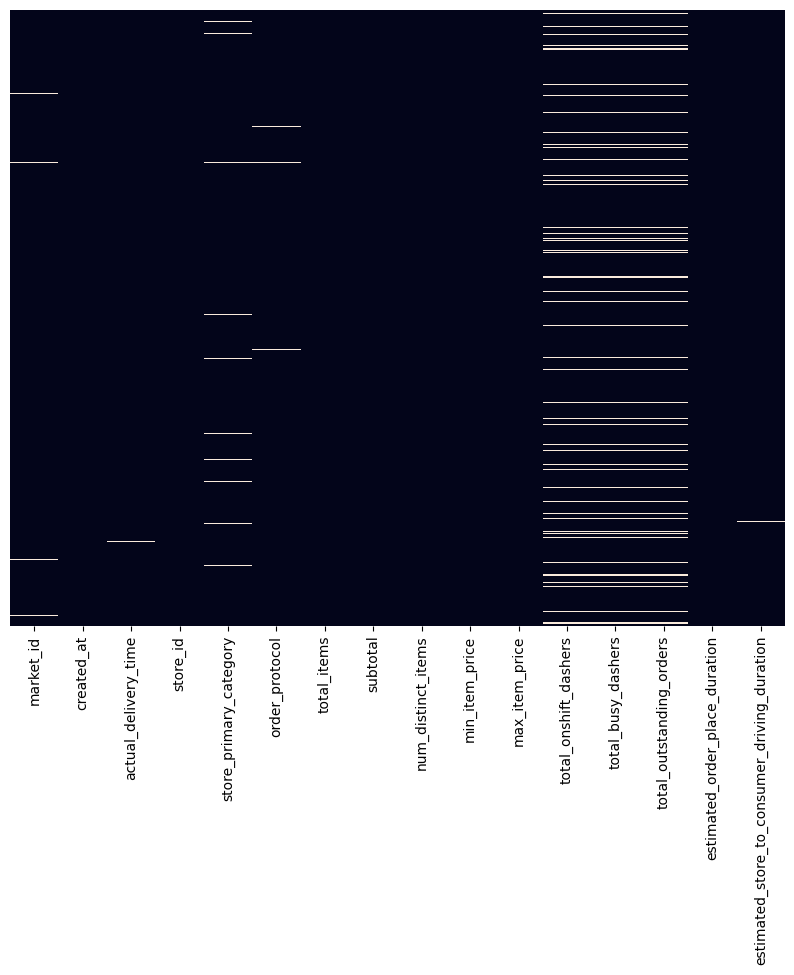

In [5]:
# Visualize the missing values
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data.isnull(), cbar=False, ax=ax)
ax.set_yticks([]);

**Observations:**

* There are missing values in some columns `market_id`, `actual_delivery_time`, `store_primary_category`, `order_protocol`, `total_onshift_dashers`, `total_busy_dashers`, `total_outstanding_orders`, and `estimated_store_to_consumer_driving_duration`.
* Columns contain information about the market features `total_onshift_dashers`, `total_busy_dashers`, and `total_outstanding_orders` have the most missing values. By looking at the graph and the number of missing values in those columns, we notice that there are some orders contain no information about the market features.
* Most columns are numeric except `created_at` and `actual_delivery_time` are "datetime" dtypes while `market_id`, `store_id`, `store_primary_category`, and `order_protocol` are "category" dtypes.

**Decisions:**

* Drop entries that have missing values in any columns since there is not any reasonable ways to impute them.
* Correct the dtype formats.


In [6]:
# Drop the missing values
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

### 2.2. Correct dtype formats

In [7]:
# Change dtypes to datetime
data['created_at'] = pd.to_datetime(data['created_at'], utc=True)
data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'], utc=True)

# Change dtypes to `int64`
data['total_onshift_dashers'] = data['total_onshift_dashers'].astype('int64')
data['total_busy_dashers'] = data['total_busy_dashers'].astype('int64')
data['total_outstanding_orders'] = data['total_outstanding_orders'].astype('int64')
data['estimated_store_to_consumer_driving_duration'] = data['estimated_store_to_consumer_driving_duration'].astype('int64')

# Change dtypes to `category`
data['store_id'] = data['store_id'].astype('category')
data['market_id'] = data['market_id'].astype('category')
data['store_primary_category'] = data['store_primary_category'].astype('category')
data['order_protocol'] = data['order_protocol'].astype('category')

In [8]:
# Check missing values and dtypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype              
---  ------                                        --------------   -----              
 0   market_id                                     175777 non-null  category           
 1   created_at                                    175777 non-null  datetime64[ns, UTC]
 2   actual_delivery_time                          175777 non-null  datetime64[ns, UTC]
 3   store_id                                      175777 non-null  category           
 4   store_primary_category                        175777 non-null  category           
 5   order_protocol                                175777 non-null  category           
 6   total_items                                   175777 non-null  int64              
 7   subtotal                                      175777 non-null  int64              
 8   num_

### 2.3. Create target variable

Since the original dataset doesn't have the label, we need to calculate it from the `created_at` and `actual_delivery_time` variables.

In [9]:
# Create target variable for building model
data['delivery_duration'] = data['actual_delivery_time'] - data['created_at']

# Change it to seconds
data['delivery_duration'] = data['delivery_duration'].apply(lambda timedelta: timedelta.total_seconds())

## 3. Create a baseline model

In [10]:
# Create a copy of the dataset
df = data.copy()

In [11]:
# One-hot encoding categorical columns
dummies = pd.get_dummies(df.loc[:, ['market_id', 'store_primary_category', 'order_protocol']], drop_first=True)
df.drop(columns=['market_id', 'created_at', 'actual_delivery_time', 'store_id', 'store_primary_category', 'order_protocol'], inplace=True)

model_df = pd.concat([df, dummies], axis=1)

In [12]:
# Have a look at the data
model_df

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,store_primary_category_turkish,store_primary_category_vegan,store_primary_category_vegetarian,store_primary_category_vietnamese,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,4,3441,4,557,1239,33,14,21,446,861,...,0,0,0,0,0,0,0,0,0,0
1,1,1900,1,1400,1400,1,2,2,446,690,...,0,0,0,0,1,0,0,0,0,0
2,4,4771,3,820,1604,8,6,18,446,289,...,0,0,0,0,0,1,0,0,0,0
3,1,1525,1,1525,1525,5,6,8,446,795,...,0,0,0,0,0,0,0,0,0,0
4,2,3620,2,1425,2195,5,5,7,446,205,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175772,3,1389,3,345,649,17,17,23,251,331,...,0,0,0,0,0,0,1,0,0,0
175773,6,3010,4,405,825,12,11,14,251,915,...,0,0,0,0,0,0,1,0,0,0
175774,5,1836,3,300,399,39,41,40,251,795,...,0,0,0,0,0,0,1,0,0,0
175775,1,1175,1,535,535,7,7,12,446,384,...,0,0,0,0,0,0,0,0,0,0


After dropped missing values and created dummies variables, the shape of the dataset changed to 175777 rows with 94 columns. Using this dataset, I'll run multiple models and then compare their performances based on their root mean squared error RMSE and runtime. From the customer's perspective, they don't want to wait such a long time for their food to be delivered. Thus, I'll use the mean squared error MSE as the loss function to penalize orders that have long duration when training the models.

First, we need to import some related libraries.

In [33]:
# Import libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm

from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time

Next, I define some functions for the training process.

The first function named `scale` that takes a scaler object in sklearn library e.g StandardScaler or MinMaxScaler and two feature dataframes with the first one for training and the second for validating. The function returns the scaled feature dataframes ordered the same as input.

The second function named `make_regression` that takes four dataframes, a scaler object, the model name, an estimator object, and a boolean value. The function initializes the model and trains it based on . If the function has a scaler object then it will call the `scale` function to scale the input features. The function then calculates the mean squared errors in training and validating processes and print them if the given boolean parameter is True, which is by default. Finally, the funtion returns the trained model, training error, and validating error.

In [66]:
def create_X_and_y(dataset):
    X = dataset.drop(columns=['delivery_duration'])
    y = dataset['delivery_duration']
    
    return X, y


def split_train_validate_test(X, y, random_state):
    X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_train_and_val, y_train_and_val, test_size=0.25, random_state=random_state)
    
    return X_train, X_val, X_test, y_train, y_val, y_test


def scale(scaler, X_train, X_val):
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    return X_train_scaled, X_val_scaled


def make_regression(dataset, scaler, model_name, model, verbose=True):
    X, y = create_X_and_y(dataset)
    
    X_train, X_val, X_test, y_train, y_val, y_test = split_train_validate_test(X, y, random_state=48)
    
    if scaler is not None:
        X_train_scaled, X_val_scaled = scale(scaler, X_train, X_val)
        model.fit(X_train_scaled, y_train)
        y_pred_train = model.predict(X_train_scaled)
        y_pred_val = model.predict(X_val_scaled)
        train_error = mean_squared_error(y_train, y_pred_train, squared=False)
        val_error = mean_squared_error(y_val, y_pred_val, squared=False)
    else:
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)
        train_error = mean_squared_error(y_train, y_pred_train, squared=False)
        val_error = mean_squared_error(y_val, y_pred_val, squared=False)
    if verbose:
        print(f'Train error = {train_error} in {model_name}')
        print(f'Val_error = {val_error} in {model_name}')
    trained_model = model
    
    return trained_model, train_error, val_error

In [ ]:
# Perform training and validating on different scalers and models
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'None': None
}

regression_models = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(),
    'RandomForest': RandomForestRegressor(),
    'XGBRegressor': XGBRegressor(),
    'LGBM': LGBMRegressor(),
}

results = {
    'scaler_name': [],
    'model_name': [],
    'train_error': [],
    'val_error': [],
    'run_time': [],
    'trained_model': [],
}

for scaler_name in scalers.keys():
    scaler = scalers[scaler_name]
    print(f'---Prediction error scaled with {scaler_name} \n')
    for model_name in regression_models.keys():
        model = regression_models[model_name]
        
        start_time = time.time()
        trained_model, train_error, val_error = make_regression(model_df, scaler, model_name, model, verbose=True)
        end_time = time.time()
        
        run_time = end_time - start_time
        print(f'Run time: {run_time:.2f} seconds in {model_name}')
        
        results['scaler_name'].append(scaler_name)
        results['model_name'].append(model_name)
        results['train_error'].append(train_error)
        results['val_error'].append(val_error)
        results['run_time'].append(run_time)
        results['trained_model'].append(trained_model)
    print('')

In [17]:
# Summary of the results
results_df = pd.DataFrame.from_dict(results)
results_df

,scaler_name,model_name,train_error,val_error,run_time,trained_model
0,StandardScaler,LinearRegression,1431.214549,2242.275163,3.198381,LinearRegression()
1,StandardScaler,DecisionTree,12.480113,2439.441009,3.370920,DecisionTreeRegressor()
2,StandardScaler,RandomForest,546.679845,2243.519740,171.150485,"(DecisionTreeRegressor(max_features=1.0, rando..."
3,StandardScaler,XGBRegressor,888.069000,2269.387361,37.963316,"XGBRegressor(base_score=0.5, booster='gbtree',..."
4,StandardScaler,LGBM,1215.939289,2233.825294,3.464951,LGBMRegressor()
5,MinMaxScaler,LinearRegression,1431.189588,2242.269763,1.487556,LinearRegression()
6,MinMaxScaler,DecisionTree,12.480113,2453.780330,3.268687,DecisionTreeRegressor()
7,MinMaxScaler,RandomForest,584.935112,2238.830277,175.573527,"(DecisionTreeRegressor(max_features=1.0, rando..."
8,MinMaxScaler,XGBRegressor,888.069000,2269.371414,34.480497,"XGBRegressor(base_score=0.5, booster='gbtree',..."
9,MinMaxScaler,LGBM,1222.156043,2235.012122,2.226831,LGBMRegressor()


From the table, we notice that scaling doesn't have a significant effect on the errors and runtime. Therefore, I decide not to scale the data. Among all of the models ran, the LightGBM model has the greatest performance both in terms of errors and runtime. Thus, it is our baseline model.

In [18]:
# Print our baseline model
results_df.iloc[14]

scaler_name                 None
model_name                  LGBM
train_error          1222.156043
val_error            2235.012122
run_time                2.019231
trained_model    LGBMRegressor()
Name: 14, dtype: object

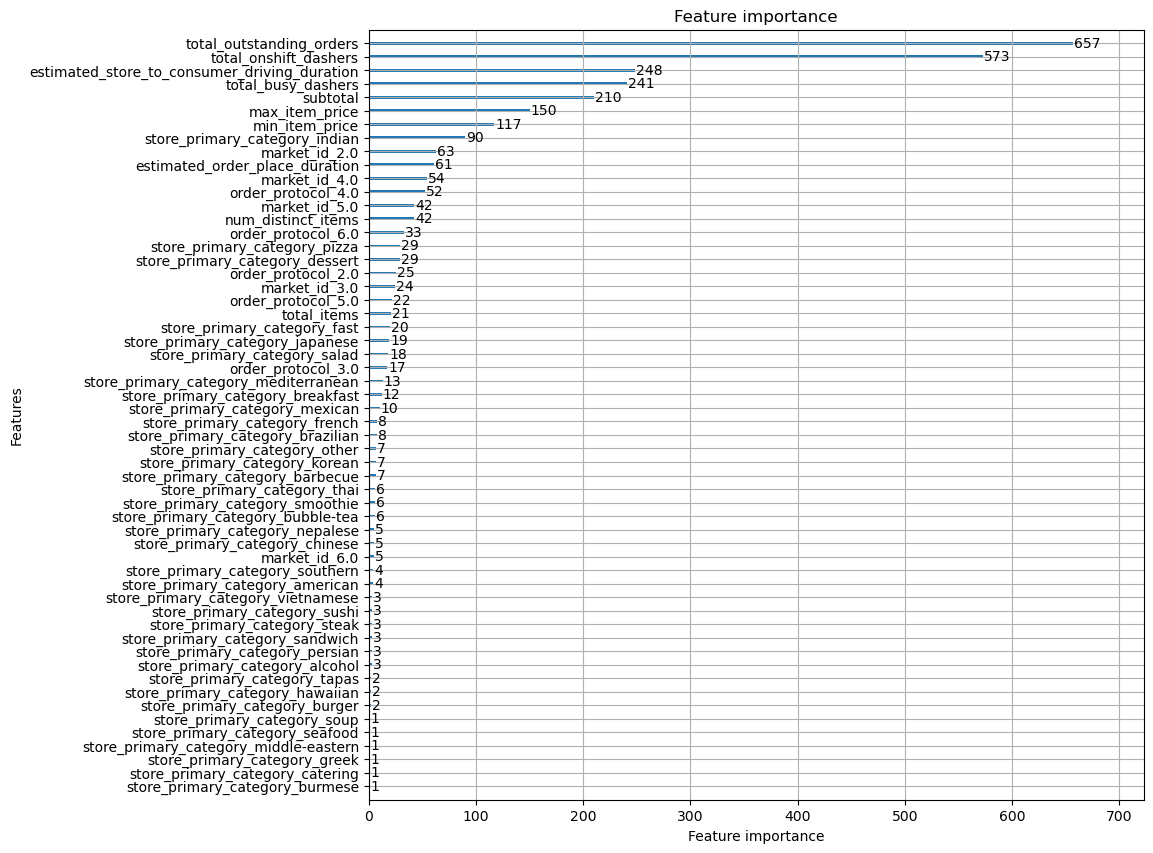

In [39]:
# Save our trained model
trained_baseline_model = results_df.loc[14, 'trained_model']

# Plot the feature importances
fig, ax = plt.subplots(figsize=(10, 10))
lightgbm.plot_importance(trained_baseline_model, ax=ax);

From the figure, the one-hot encoded categorical columns `market_id`, `store_primary_category`, and `order_protocol` don't have much impact on predicting the delivery time. Thus, we can consider to remove them from the dataset.

Given the results from the baseline model, I'll try to improve it by making some changes to the data. First, I'll check if the dataset contains any outliers and remove them.

### 2.4. Detect outliers

In [20]:
# Descriptive statistics
data.describe()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration
count,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000,175777.000000
mean,3.204976,2697.111147,2.675060,684.965433,1160.158616,44.918664,41.861381,58.230115,307.818105,546.077240,2866.422672
std,2.674055,1828.554893,1.625681,519.882924,560.828571,34.544724,32.168505,52.731043,89.796587,218.717798,1660.741001
min,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,101.000000
25%,2.000000,1412.000000,1.000000,299.000000,799.000000,17.000000,15.000000,17.000000,251.000000,384.000000,2105.000000
50%,3.000000,2224.000000,2.000000,595.000000,1095.000000,37.000000,35.000000,41.000000,251.000000,544.000000,2662.000000
75%,4.000000,3410.000000,3.000000,942.000000,1395.000000,66.000000,63.000000,85.000000,446.000000,703.000000,3383.000000
max,411.000000,26800.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000,373879.000000


In [21]:
# Descriptive statistics
data.describe(include='category')

,market_id,store_id,store_primary_category,order_protocol
count,175777.0,175777,175777,175777.0
unique,6.0,5645,73,7.0
top,2.0,6865,american,1.0
freq,53469.0,923,18183,48404.0


**Observations:**

With numerical variables:

* The column `order_protocol` shows that a store can receive orders from DoorDash through 7 distinct modes.
* The column `total_items` shows that the 75% percentitle is 4 while the maximum is 411 (likely be an outlier).
* The column `subtotal` shows that the average value of an order is 26.97$ and the maximum is 268.00$. Interestingly, the minimum value of an order is 0.00$ or completely free.
* The column `num_distinct_items` shows that an order likely has either 2 or 3 number of distinct items and the maximum is 20 distinct items.
* The column `min_item_price` shows that the minimum price of the item with the least cost in the order is -0.86$ (clearly unreasonable), the maximum is 147.00$, and the average is about 6.85$.
* The column `max_item_price` shows that the maximum price of the item with the highest cost in the order is 0.00$, the maximum is 147.00$, and the average is about 11.60$.
* The columns `total_onshift_dashers`, `total_busy_dashers`, and `total_outstanding_orders` all have the minimum values are negative (unreasonable).
* The column `estimated_order_place_duration` shows that an order takes, on average, about 5 minutes for the restaurant to receive the order from DoorDash. While an order can get instantly delivered, it can take up to the maximum of about 45 minutes.
* The column `estimated_store_to_consumer_driving_duration` shows that the average estimated travel time is about 9.1 minutes, the minimum is 0 minutes and the maximum is about 34.8 minutes.
* The column `deliery_duration` shows that the average delivery time is about 48 minutes, the minimum is about 1 minute, and interestingly the maximum is more than 4 days.

With categorical variables:

* The column `market_id` shows that the dataset was collected in 6 different cities/regions but the orders were mostly collected in city/region with id 2 (about 30%)
* The column `store_id` shows that there are 5645 restaurants were recorded, and the restaurant whose id is 6865 is the most frequent.
* The column `store_primary_category` shows that there are 73 unique primary category among the restaurants with american is the most frequent.
* The column `order_protocol` shows that a store can receive orders from DoorDash through 7 distinct modes but mostly through mode 1.

Based on the observations, we can clearly tell that there are some outliers in our dataset. By using visual method, I'm able to identify any data points that fall far outside the expected range and decide to remove them.

In [22]:
# Get the numerical columns
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns.to_list()
print(f'There are {len(numerical_columns)} numerical columns in the dataset which are {numerical_columns}')

There are 11 numerical columns in the dataset which are ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration', 'delivery_duration']


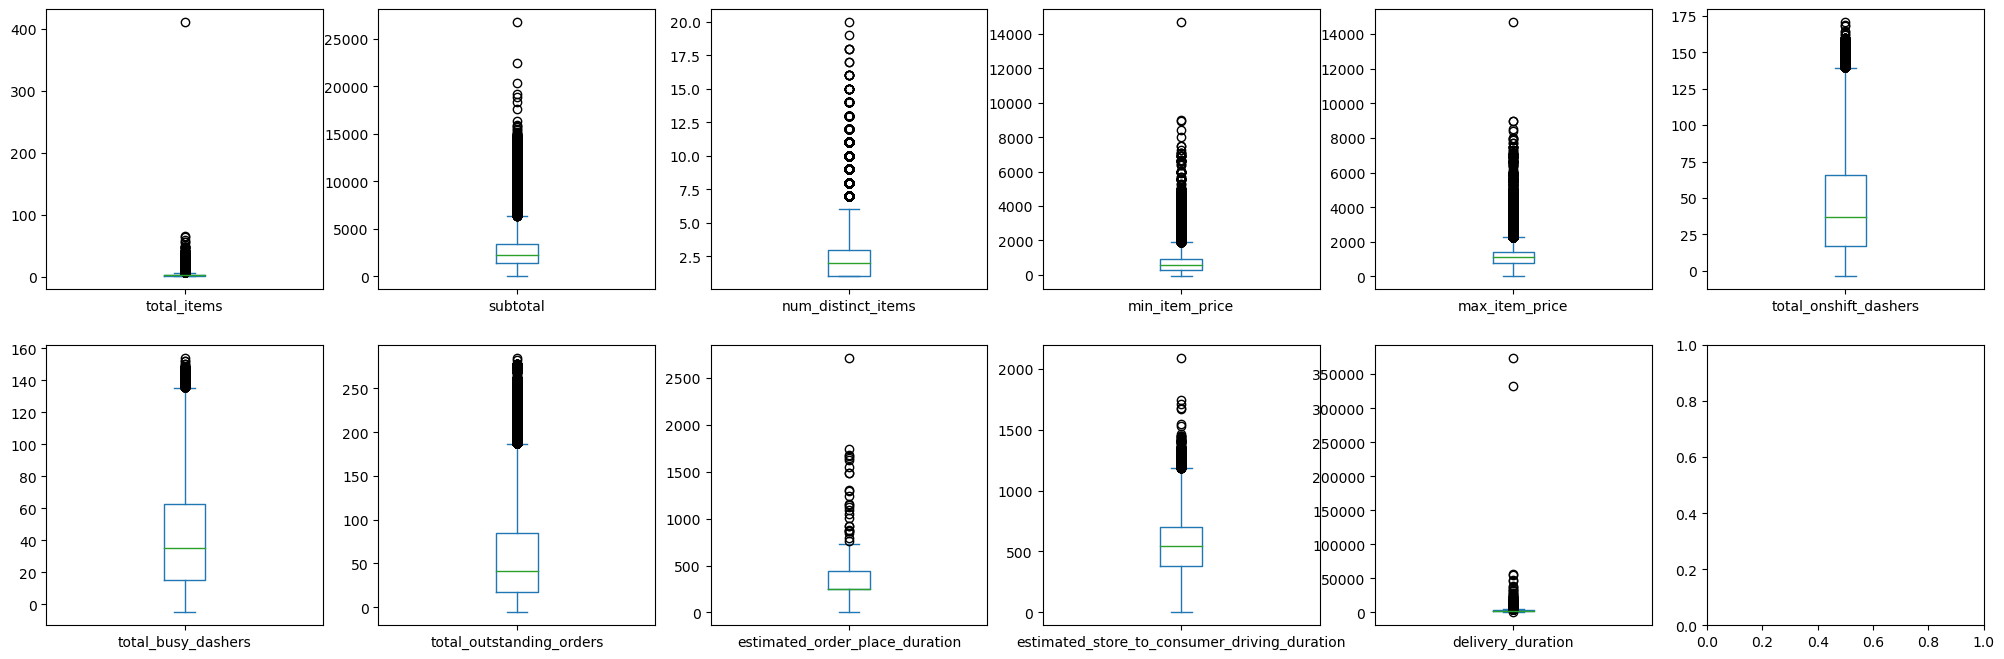

In [23]:
# Create a series of boxplots for numerical columns in the dataset
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(25, 8))

for column, ax in zip(numerical_columns, axes.ravel()):
    data[column].plot(kind='box', ax=ax)

By looking at the figure, we can see that the dots are outliers and they should be removed from the dataset.

In [25]:
# Remove the outliers 
data = data.loc[
    (data['total_items'] < data['total_items'].quantile(0.85)) &
    (data['subtotal'] < data['subtotal'].quantile(0.90)) & 
    (data['num_distinct_items'] < data['num_distinct_items'].quantile(0.99)) &
    (data['min_item_price'] < data['min_item_price'].quantile(0.97)) & 
    (data['max_item_price'] < data['max_item_price'].quantile(0.95)) &
    (data['total_onshift_dashers'] < data['total_onshift_dashers'].quantile(0.99)) &
    (data['total_busy_dashers'] < data['total_busy_dashers'].quantile(0.99)) &
    (data['total_outstanding_orders'] < data['total_outstanding_orders'].quantile(0.95)) &
    (data['estimated_order_place_duration'] < data['estimated_order_place_duration'].quantile(0.99)) &
    (data['estimated_store_to_consumer_driving_duration'] < data['estimated_store_to_consumer_driving_duration'].quantile(0.99)) &
    (data['delivery_duration'] < data['delivery_duration'].quantile(0.95))
    ]

In some columns such as `min_item_price`, the minimum values can't be negative. They should be removed also.

In [26]:
# Remove negative values
data = data.loc[
    (data['min_item_price'] >=0) &
    (data['total_onshift_dashers'] >= 0) &
    (data['total_busy_dashers'] >= 0) &
    (data['total_outstanding_orders'] >= 0)
]

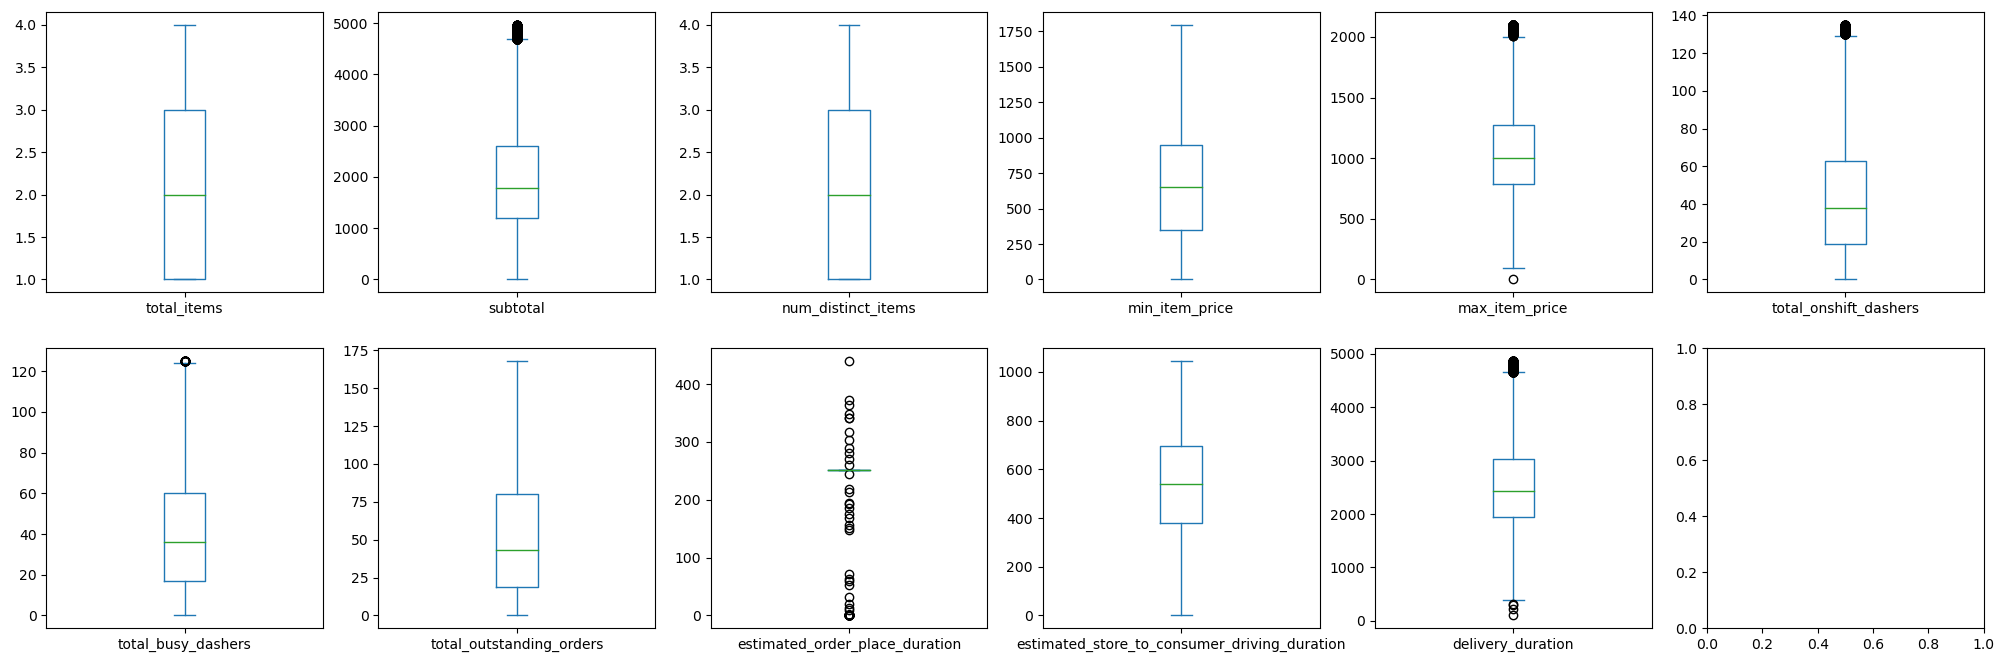

In [27]:
# Check the boxplots to see the changes
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(25, 8))

for column, ax in zip(numerical_columns, axes.ravel()):
    data[column].plot(kind='box', ax=ax)

The boxplots look better now with many outliers have been removed.

In [28]:
# Reset the index of the dataset
data.reset_index(drop=True, inplace=True)

In [29]:
# Have a look at the data
data

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_duration
0,3.0,2015-01-30 19:49:30+00:00,2015-01-30 20:28:45+00:00,4149,sandwich,2.0,4,3490,3,175,850,16,16,21,251,298,2355.0
1,2.0,2015-02-09 20:29:30+00:00,2015-02-09 21:17:34+00:00,4149,thai,5.0,1,1220,1,825,825,21,21,20,251,835,2884.0
2,1.0,2015-01-27 18:32:58+00:00,2015-01-27 19:02:09+00:00,3201,cafe,4.0,2,595,2,200,295,5,1,1,251,186,1751.0
3,3.0,2015-02-18 04:26:00+00:00,2015-02-18 05:05:00+00:00,2004,american,5.0,2,2800,2,1000,1800,18,15,15,251,821,2340.0
4,3.0,2015-02-17 21:34:38+00:00,2015-02-17 22:04:26+00:00,2004,american,5.0,2,2641,2,625,1240,27,22,24,251,89,1788.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83132,1.0,2015-02-07 03:13:16+00:00,2015-02-07 04:29:49+00:00,2956,fast,4.0,3,1952,3,345,505,69,69,94,251,551,4593.0
83133,1.0,2015-01-29 01:41:57+00:00,2015-01-29 02:40:45+00:00,2956,fast,4.0,3,1398,3,200,639,38,38,49,251,899,3528.0
83134,1.0,2015-01-26 21:25:12+00:00,2015-01-26 22:21:22+00:00,2956,fast,4.0,1,809,1,729,729,20,18,18,251,818,3370.0
83135,2.0,2015-02-18 02:16:04+00:00,2015-02-18 03:12:36+00:00,2956,indian,3.0,3,2352,3,499,685,49,49,65,251,560,3392.0


## 3. Feature engineering

After removed the outliers, the length of the dataset has significantly decreased from 175777 to 83137 meaning that half of the orders contains at least an outlier. Next, I'll created some new features, and since the baseline model was trained without the information of the `created_at` and `actual_delivery_time` columns, I give more focus to extract information from these to columns. Because the dataset was collected in either January 2015 or February 2015, I decide not to extract the month nor the year. Also, I notice that the delivery process usually created and delivered within the same day. Therefore, the information about the day of month will only be extracted from the variable `created_at`.

In [30]:
# Create a column containing information about whether the order placed is in working time (from 9:00 AM to 5:00 PM)
data['created_at_hour'] = data['created_at'].dt.hour + data['created_at'].dt.minute / 60
data['is_working_time'] = data['created_at_hour'].apply(lambda x: 1 if (x >= 9) and (x <= 17) else 0)

# Create a column containing information about the day of `created_at`
data['created_at_day'] = data['created_at'].dt.day

# Create a column containing information about the day of week of `created_at`
day_of_week_mapper = {
    0: 'Monday', 
    1: 'Tuesday', 
    2: 'Wednesday', 
    3: 'Thursday', 
    4: 'Friday',
    5: 'Saturday', 
    6: 'Sunday'
}
data['created_at_day_of_week'] = data['created_at'].dt.weekday.map(day_of_week_mapper).astype('category')

# Create a column containing the average total value of an order
data['average_value'] = data['subtotal'] / data['total_items']

# Create a column containing estimated minimum wait duration
data['estimated_minimum_wait_duration'] = data['estimated_order_place_duration'] + data['estimated_store_to_consumer_driving_duration']

# Create a column containing information about the available_dashers
data['available_dashers'] = data['total_onshift_dashers'] - data['total_busy_dashers']

# Create a column containing information about whether there is any avaiable dashers
data['is_available'] = data['available_dashers'].apply(lambda x: 1 if x > 0 else 0)


I've just created 8 new features:

* Feature `created_at_hour` contains information of the hour when the order was created.
* Feature `is_working_time` contains information of whether the order was created during working time (9:00 AM to 5:00 PM) or not.
* Feature `created_at_day` contains information of the day of month when the order was created.
* Feature `created_at_day_of_week` contains information of the day of week when the order was created.
* Feature `average_value` contains information of the average value of an order.
* Feature `estimated_minimum_wait_duration` contains information of the sum of the predicted durations.
* Feature `available_dashers` contains information of the number of available_dashers within 10 miles of the restaurant.
* Feature `is_available` contains information of whether there are any available dashers or not.

In [41]:
# Have a look at the dataset
data.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,delivery_duration,created_at_month,created_at_day,created_at_day_of_week,average_value,estimated_minimum_wait_duration,created_at_hour,is_working_time,available_dashers,is_available
0,3.0,2015-01-30 19:49:30+00:00,2015-01-30 20:28:45+00:00,4149,sandwich,2.0,4,3490,3,175,...,2355.0,1,30,Friday,872.5,549,19.816667,0,0,0
1,2.0,2015-02-09 20:29:30+00:00,2015-02-09 21:17:34+00:00,4149,thai,5.0,1,1220,1,825,...,2884.0,2,9,Monday,1220.0,1086,20.483333,0,0,0
2,1.0,2015-01-27 18:32:58+00:00,2015-01-27 19:02:09+00:00,3201,cafe,4.0,2,595,2,200,...,1751.0,1,27,Tuesday,297.5,437,18.533333,0,4,1
3,3.0,2015-02-18 04:26:00+00:00,2015-02-18 05:05:00+00:00,2004,american,5.0,2,2800,2,1000,...,2340.0,2,18,Wednesday,1400.0,1072,4.433333,0,3,1
4,3.0,2015-02-17 21:34:38+00:00,2015-02-17 22:04:26+00:00,2004,american,5.0,2,2641,2,625,...,1788.0,2,17,Tuesday,1320.5,340,21.566667,0,5,1


## 4. Modeling

As mentioned after plotting the feature importances, the categorical features seem to be trivial and could be remove. However, I want to see if the statement is truely correct or not by creating two datasets with the first contains the categorical variables and the second does not (except `created_at_day_of_week`). They will be used for training two LightGBM models and evaluated based on the results. The one that creates better results is kept for tunning the hyperparameters of the LightGBM model.

In [57]:
# Create a copy of data for modeling
model_data = data.copy()

# Create a dataset that contains one-hot encoded categorical variables
dummies = pd.get_dummies(model_data.loc[: , ['market_id', 'store_primary_category', 'order_protocol', 'created_at_day_of_week']], drop_first=True)
temp_data = model_data.drop(columns=['market_id', 'created_at', 'actual_delivery_time', 'store_id', 'store_primary_category', 'order_protocol', 'created_at_day_of_week'])
dataset_with_categorical = pd.concat([temp_data, dummies], axis=1)

# Create a dataset that does not contain categorical variables except `created_at_day_of_week`
dummies = pd.get_dummies(model_data.loc[:, 'created_at_day_of_week'], drop_first=True)
temp_data = model_data.drop(columns=['market_id', 'created_at', 'actual_delivery_time', 'store_id', 'store_primary_category', 'order_protocol', 'created_at_day_of_week'])
dataset_without_categorical = pd.concat([temp_data, dummies], axis=1)

In [58]:
# Have a look at the `model_data_with_categorical` dataset
dataset_with_categorical.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0,created_at_day_of_week_Monday,created_at_day_of_week_Saturday,created_at_day_of_week_Sunday,created_at_day_of_week_Thursday,created_at_day_of_week_Tuesday,created_at_day_of_week_Wednesday
0,4,3490,3,175,850,16,16,21,251,298,...,0,0,0,0,0,0,0,0,0,0
1,1,1220,1,825,825,21,21,20,251,835,...,0,1,0,0,1,0,0,0,0,0
2,2,595,2,200,295,5,1,1,251,186,...,1,0,0,0,0,0,0,0,1,0
3,2,2800,2,1000,1800,18,15,15,251,821,...,0,1,0,0,0,0,0,0,0,1
4,2,2641,2,625,1240,27,22,24,251,89,...,0,1,0,0,0,0,0,0,1,0


In [59]:
# Have a look at the `model_data_without_categorical` dataset
dataset_without_categorical.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,created_at_hour,is_working_time,available_dashers,is_available,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,4,3490,3,175,850,16,16,21,251,298,...,19.816667,0,0,0,0,0,0,0,0,0
1,1,1220,1,825,825,21,21,20,251,835,...,20.483333,0,0,0,1,0,0,0,0,0
2,2,595,2,200,295,5,1,1,251,186,...,18.533333,0,4,1,0,0,0,0,1,0
3,2,2800,2,1000,1800,18,15,15,251,821,...,4.433333,0,3,1,0,0,0,0,0,1
4,2,2641,2,625,1240,27,22,24,251,89,...,21.566667,0,5,1,0,0,0,0,1,0


In [73]:
results = {
    'dataset': [],
    'model_name': [],
    'train_error': [],
    'val_error': [],
    'run_time': [],
    'trained_model': [],
}

datasets = {
    'dataset_with_categorical': dataset_with_categorical,
    'dataset_without_categorical': dataset_without_categorical
}

for dataset_name, dataset in datasets.items():
    print(f'---Prediction error using {dataset_name}---\n')
    model_name = 'LGBM'
    model = LGBMRegressor()
    
    start_time = time.time()
    trained_model, train_error, val_error = make_regression(dataset=dataset, scaler=None, model_name=model_name, model=model, verbose=True)
    end_time = time.time()
    
    rut_time = end_time - start_time
    print(f'Run time: {run_time:.2f}\n')
    
    results['dataset'].append(dataset_name)
    results['model_name'].append(model_name)
    results['train_error'].append(train_error)
    results['val_error'].append(val_error)
    results['run_time'].append(run_time)
    results['trained_model'].append(trained_model)

---Prediction error using dataset_with_categorical---

Train error = 628.5085631909747 in LGBM
Val_error = 656.5164285914565 in LGBM
Run time: 3.53

---Prediction error using dataset_without_categorical---

Train error = 637.9878494100136 in LGBM
Val_error = 666.4903758582716 in LGBM
Run time: 3.53



In [74]:
results_df = pd.DataFrame.from_dict(results)
results_df

,dataset,model_name,train_error,val_error,run_time,trained_model
0,dataset_with_categorical,LGBM,628.508563,656.516429,3.534493,LGBMRegressor()
1,dataset_without_categorical,LGBM,637.987849,666.490376,3.534493,LGBMRegressor()


The results indicate that by removing outliers and adding new features, the performance has significantly improved. However, the use of datasets with or without the categorical variables doesn't have a big impact on performance, but the dataset with the categorical variables has a slightly better results than the dataset without the categorical variables. Thus, it will be kept for tunning some hyperparameters in the LighGBM model to see if the results can be better.

In [ ]:
# Compute the correlation matrix
corr = model_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [76]:
# Perform hyperparameters tuning
param_grid = {
    'num_leaves': [70, 100, 130],
    'max_depth': [6, 8, 10],
    'min_data_in_leaf': [300, 600, 900],
}

X, y = create_X_and_y(dataset=dataset_with_categorical)

X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search = GridSearchCV(LGBMRegressor(), param_grid=param_grid, n_jobs=-1, cv=10, scoring='neg_mean_squared_error')

grid_search.fit(X_train_and_val, y_train_and_val)

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGB

GridSearchCV(cv=10, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'max_depth': [6, 8, 10],
                         'min_data_in_leaf': [300, 600, 900],
                         'num_leaves': [70, 100, 130]},
             scoring='neg_mean_squared_error')

In [77]:
# Get the results from the best model
y_pred = grid_search.predict(X_test)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Test RMSE: {test_rmse:.4f} using parameters {grid_search.best_params_}')

Test RMSE: 650.2979 using parameters {'max_depth': 10, 'min_data_in_leaf': 300, 'num_leaves': 130}


After apply tuning on some hyperparameters, the test root mean squared error is 650.2979 seconds, which is about 11 minutes.

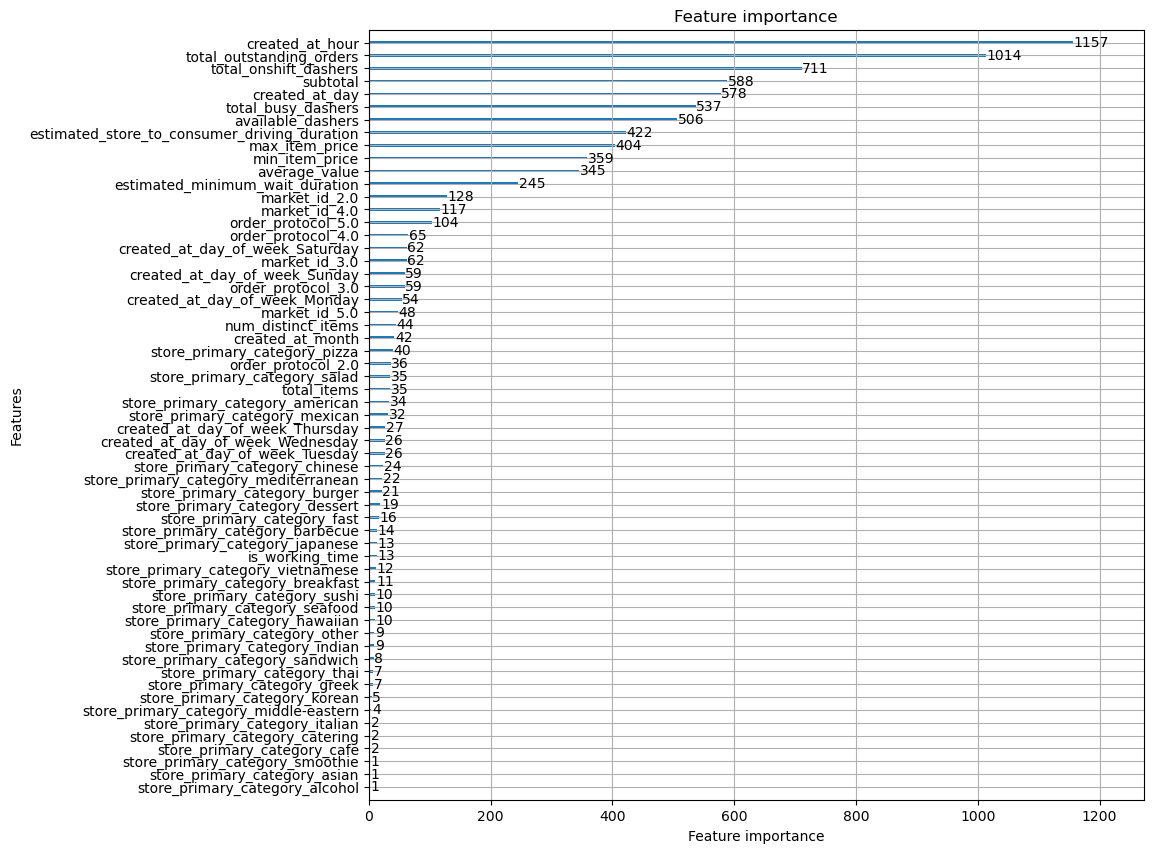

In [81]:
# Plot feature importances
fig, ax = plt.subplots(figsize=(10, 10))
lightgbm.plot_importance(grid_search.best_estimator_, ax=ax);

In [82]:
# Summary of feature importances
feature_importance_dict = {
    'index': X.columns,
    'feature_importance': grid_search.best_estimator_.feature_importances_
}
feature_importance_df = pd.DataFrame.from_dict(feature_importance_dict)
feature_importance_df.sort_values(by='feature_importance', ascending=False).reset_index(drop=True).head(10)

,index,feature_importance
0,created_at_hour,1157
1,total_outstanding_orders,1014
2,total_onshift_dashers,711
3,subtotal,588
4,created_at_day,578
5,total_busy_dashers,537
6,available_dashers,506
7,estimated_store_to_consumer_driving_duration,422
8,max_item_price,404
9,min_item_price,359
